## PROJECT 3 - PART D

### ASSEMBLY OF KETO AND WINE DATAFRAMES,  EDA AND MODELING

**OVERVIEW**

At this stage we will be focusing on:

- Balancing the data we collected between our two datafames to drive an effective train-test-split without having to deal with unbalanced classes.
- Concatenating the two dataframes and focusing our features on the most important and most text-rich elements. 
- Combining our text columns to optimize our use of the vectorizer
- Conducting EDA on our data to extract insights on word counts and distribution between both subreddits
- Running our Logistic Regression and Multinomial Naive Bayes models 
- Analyzing our Accuracy scores, as well as Sensitivity and Specificity through an ROC AUC chart


**PREPARATION**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import nltk
import json
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import regex as re

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [2]:
keto= pd.read_csv('keto_push_clean.csv')
keto.drop(columns = ['Unnamed: 0'],inplace=True)

In [3]:
wine= pd.read_csv('wine_push_clean.csv')
wine.drop(columns = ['Unnamed: 0'],inplace=True)

**BALANCE THE DATAFRAMES**

In [4]:
keto.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,It's been a hot minute,I keep getting off track when it comes to keto...,keto,1580160840,bbwsoontobebw,5,1,True,2020-01-27
1,Type 1 Diabetes on Keto,"Hello, I’m beginning my second month of keto. ...",keto,1580160905,iWantNotToWant,10,1,True,2020-01-27
2,"Week 3,5 and intense cravings for bread and rice","Week 3,5 and I am having intense cravings for ...",keto,1580161118,littleboo2theboo,10,1,True,2020-01-27
3,12-Week Challenge at the gym and looking for t...,"Hi guys,\n\nI am looking for some advice. I di...",keto,1580161503,chow_shepard,4,1,True,2020-01-27
4,"Does never going ""Full Keto"" hurt my health?",Hello!\n\nI'm a active highschooler who avoids...,keto,1580161639,OrganizingChaosBrb,3,1,True,2020-01-27


In [5]:
wine.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Looking for a summer job,"Hi,\n\nI'm a 23 year-old man from the Netherla...",wine,1580165102,Loirettoux,3,1,True,2020-01-27
1,California whites,"Whenever I try a Californian wine, it's always...",wine,1580170191,RaphGiroux,8,1,True,2020-01-27
2,Wine suggestions while in France (Provence),Will be traveling to France and spending most ...,wine,1580177480,irishmuse,4,1,True,2020-01-27
3,Show me the Munny Hunny | Wine Industry Report...,"If you are in the wine industry, congratulatio...",wine,1580177690,cudaeducation,0,1,True,2020-01-27
4,Going to Burgundy in May,"Hi, I'll be going to Burgundy during May and w...",wine,1580182920,GaanZi,5,1,True,2020-01-27


In [6]:
keto.shape

(7894, 9)

In [7]:
wine.shape

(2882, 9)

In [8]:
remove_n = 5012
drop_indices = np.random.choice(keto.index, remove_n, replace=False)
keto_subset = keto.drop(drop_indices)

In [9]:
keto_subset.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,It's been a hot minute,I keep getting off track when it comes to keto...,keto,1580160840,bbwsoontobebw,5,1,True,2020-01-27
2,"Week 3,5 and intense cravings for bread and rice","Week 3,5 and I am having intense cravings for ...",keto,1580161118,littleboo2theboo,10,1,True,2020-01-27
4,"Does never going ""Full Keto"" hurt my health?",Hello!\n\nI'm a active highschooler who avoids...,keto,1580161639,OrganizingChaosBrb,3,1,True,2020-01-27
7,Any Runners...,Hello Keto world!!\n\nI am wondering if there ...,keto,1580163761,SinfullyGood1974,12,1,True,2020-01-27
9,"NSV: January 2019 - 56"" waist jeans. January 2...",Hey Ketoers!\n\nAs the subject line. Before I ...,keto,1580164528,opalfruity,5,1,True,2020-01-27


**COMBINE THE DATAFRAMES AND FOCUS FEATURES**

In [10]:
keto_wine = pd.concat([keto_subset,wine])

In [11]:
keto_wine.drop(columns=['created_utc','author','num_comments','score','is_self','timestamp'], inplace=True)

In [12]:
keto_wine['subreddit']=keto_wine['subreddit'].map({'keto':0,'wine':1})

In [13]:
keto_wine.reset_index(drop=True)

,title,selftext,subreddit
0,It's been a hot minute,I keep getting off track when it comes to keto...,0
1,"Week 3,5 and intense cravings for bread and rice","Week 3,5 and I am having intense cravings for ...",0
2,"Does never going ""Full Keto"" hurt my health?",Hello!\n\nI'm a active highschooler who avoids...,0
3,Any Runners...,Hello Keto world!!\n\nI am wondering if there ...,0
4,"NSV: January 2019 - 56"" waist jeans. January 2...",Hey Ketoers!\n\nAs the subject line. Before I ...,0
...,...,...,...
5759,Best place to ask quick questions about wine?,Is there a separate sub where newbies can ask ...,1
5760,Pairing wine with oral sex (NSFW),**this is a serious post. I’m not trolling**\n...,1
5761,"(Not a wine expert) Found an old wine, can som...",Hey!\nI dig out an old bottle my mom got a goo...,1
5762,Basic Wine Cellar Question,Good afternoon Reditors.\n\nI am having some f...,1


**COMBINE TITLE AND SELFTEXT COLUMNS TO PREP FOR VECTORIZER** 

In [14]:
keto_wine['titleself']=keto_wine['title']+' '+keto_wine['selftext']
keto_wine

,title,selftext,subreddit,titleself
0,It's been a hot minute,I keep getting off track when it comes to keto...,0,It's been a hot minute I keep getting off trac...
2,"Week 3,5 and intense cravings for bread and rice","Week 3,5 and I am having intense cravings for ...",0,"Week 3,5 and intense cravings for bread and ri..."
4,"Does never going ""Full Keto"" hurt my health?",Hello!\n\nI'm a active highschooler who avoids...,0,"Does never going ""Full Keto"" hurt my health? H..."
7,Any Runners...,Hello Keto world!!\n\nI am wondering if there ...,0,Any Runners... Hello Keto world!!\n\nI am wond...
9,"NSV: January 2019 - 56"" waist jeans. January 2...",Hey Ketoers!\n\nAs the subject line. Before I ...,0,"NSV: January 2019 - 56"" waist jeans. January 2..."
...,...,...,...,...
2877,Best place to ask quick questions about wine?,Is there a separate sub where newbies can ask ...,1,Best place to ask quick questions about wine? ...
2878,Pairing wine with oral sex (NSFW),**this is a serious post. I’m not trolling**\n...,1,Pairing wine with oral sex (NSFW) **this is a ...
2879,"(Not a wine expert) Found an old wine, can som...",Hey!\nI dig out an old bottle my mom got a goo...,1,"(Not a wine expert) Found an old wine, can som..."
2880,Basic Wine Cellar Question,Good afternoon Reditors.\n\nI am having some f...,1,Basic Wine Cellar Question Good afternoon Redi...


In [15]:
X=keto_wine['titleself']
y=keto_wine.subreddit

In [16]:
# Assess y
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [17]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                   random_state=42)

**APPLY VECTORIZER**

In [18]:
cvec=CountVectorizer(stop_words='english',max_features=1000,ngram_range=(1,2))

In [19]:
cvec.fit(X_train)
# cvec.fit(keto_wine['titleself'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [20]:
print(cvec.vocabulary_)

{'major': 556, 'cooking': 197, 'night': 612, 'low': 545, 'carb': 140, 'carbs': 141, 'place': 667, '10': 0, 'bread': 117, '12': 3, 'cheese': 162, 'pizza': 666, 'ready': 708, 'eat': 266, 'fat': 304, 'food': 329, 'like': 512, 'hard': 393, 'feel': 307, 'missing': 582, 'usually': 917, 'add': 41, 'salad': 749, 'enjoy': 276, 'keto': 475, 'cause': 147, 'progress': 695, 'makes': 559, 'pay': 656, 'low carb': 546, 'feel like': 308, 'napa': 597, 'winery': 970, 'birthday': 99, 'trip': 902, 'november': 621, 'visiting': 935, 'recommendations': 719, 'wineries': 969, 'visit': 934, 'time': 883, 'excited': 284, 'finally': 316, 'best': 96, 'wine': 965, 'use': 914, 'job': 463, 'pounds': 680, 'right': 741, 'know': 488, 'healthy': 399, 'weight': 955, 've': 921, 'trying': 906, 'months': 589, 'scale': 757, 'won': 973, 'stay': 816, 'deficit': 228, 'pretty': 686, 'average': 76, 'day': 221, 'workout': 978, 'couple': 205, 'times': 884, 'week': 949, 'cardio': 143, 'just': 468, 'ton': 891, 'water': 944, 'super': 846

In [21]:
X_train_cvec = cvec.transform(X_train)

In [22]:
X_test_cvec = cvec.transform(X_test)

In [23]:
keto_wine_train = pd.DataFrame(X_train_cvec.toarray(),
                        columns=cvec.get_feature_names())
keto_wine_train

,10,100,11,12,13,14,15,150,16,18,...,year,year old,years,years ago,yes,yesterday,yogurt,young,youtube,zero
0,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3859,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
keto_wine_test = pd.DataFrame(X_test_cvec.toarray(),
                        columns=cvec.get_feature_names())
keto_wine_test

,10,100,11,12,13,14,15,150,16,18,...,year,year old,years,years ago,yes,yesterday,yogurt,young,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1901,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


**CONDUCT EDA ON THE RESULTING DATA SETS**

Text(0.5, 1.0, 'MOST FREQUENT WORDS IN KETO AND WINE SUBREDDITS')

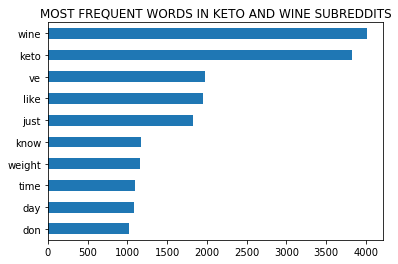

In [25]:
keto_wine_train.sum().sort_values().tail(10).plot(kind = 'barh');

plt.title("MOST FREQUENT WORDS IN KETO AND WINE SUBREDDITS")



Text(0.5, 1.0, 'LEAST FREQUENT WORDS IN KETO AND WINE SUBREDDITS')

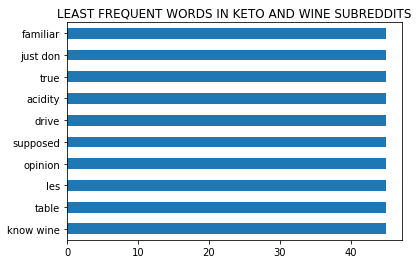

In [26]:
keto_wine_train.sum().sort_values().head(10).plot(kind='barh');

plt.title("LEAST FREQUENT WORDS IN KETO AND WINE SUBREDDITS")



**INSTANTIATE LOGREG MODEL AND CONTINUE EDA** 

In [27]:
lr=LogisticRegression()

In [28]:
lr.fit(X_train_cvec,y_train)

C:\Users\tonyb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
lr.coef_

array([[ 2.88859235e-01, -5.03278532e-02, -9.00657591e-02,
         4.73908551e-02,  3.35556713e-02, -2.79649609e-02,
         1.32436567e-01, -2.36891353e-02, -1.82370353e-01,
        -5.27925197e-02,  1.07685059e-01, -1.78811984e-01,
        -9.61789868e-02,  1.55407528e-01,  5.31832221e-02,
         1.61341506e-01,  1.21197430e-01,  3.29789600e-01,
         3.04559783e-01,  5.77499600e-01,  5.26633002e-02,
         2.71695672e-01,  1.48791777e-01, -7.72724220e-02,
        -5.62556349e-02,  1.88160090e-01,  1.28541878e-01,
        -1.91400101e-01,  5.72764208e-02, -7.82327162e-02,
         9.16997726e-02, -4.99281316e-02, -5.61738884e-02,
         1.78592128e-01,  1.34079795e-03,  1.81915677e-01,
        -3.18101989e-01,  2.76153064e-01,  6.08299321e-02,
         3.85922656e-02,  1.68060668e-01, -2.75591193e-01,
        -1.34793419e-01,  1.32281329e-01, -6.85178737e-04,
        -1.92328003e-01,  4.79782040e-01,  6.88721657e-02,
         1.35561530e-01,  1.74846439e-01, -5.28579119e-0

In [30]:
np.exp(lr.coef_)

array([[ 1.33490381,  0.95091761,  0.91387109,  1.04853175,  1.03412501,
         0.97242244,  1.1416066 ,  0.97658925,  0.83329267,  0.9485768 ,
         1.11369694,  0.83626312,  0.90830143,  1.16813391,  1.05462286,
         1.1750862 ,  1.12884776,  1.3906755 ,  1.35602793,  1.7815782 ,
         1.05407468,  1.31218761,  1.16043134,  0.92563766,  0.94529745,
         1.20702673,  1.13716904,  0.82580212,  1.05894849,  0.9247492 ,
         1.09603571,  0.95129779,  0.94537473,  1.19553302,  1.0013417 ,
         1.19951304,  0.72752858,  1.3180496 ,  1.06271816,  1.03934662,
         1.18300838,  0.7591232 ,  0.87389642,  1.14142939,  0.99931506,
         0.82503621,  1.6157222 ,  1.07129925,  1.14517966,  1.1910633 ,
         0.5894419 ,  0.90385651,  1.02492774,  0.60438149,  0.98260075,
         1.23380359,  1.48020965,  1.13191216,  0.87423515,  0.98641999,
         0.97555405,  0.99143458,  1.25506649,  0.82522728,  1.07941276,
         1.55529324,  1.0426417 ,  1.16944483,  0.7

In [31]:
preds = lr.predict(X_test_cvec)

In [32]:
preds

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [33]:
#lr.score provides us with the accuracy score
lr.score(X_test_cvec,y_test)

0.9852863899106674

**ROC AUC CURVE**

In [34]:
# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

array([[926,  26],
       [  2, 949]], dtype=int64)

In [35]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Note that .ravel() will arrange items in a one-dimensional array.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html

In [36]:
# What is the specificity of our test set?

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9727


In [37]:
# What is the sensitivity of our test set?

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9979


In [38]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_test_cvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

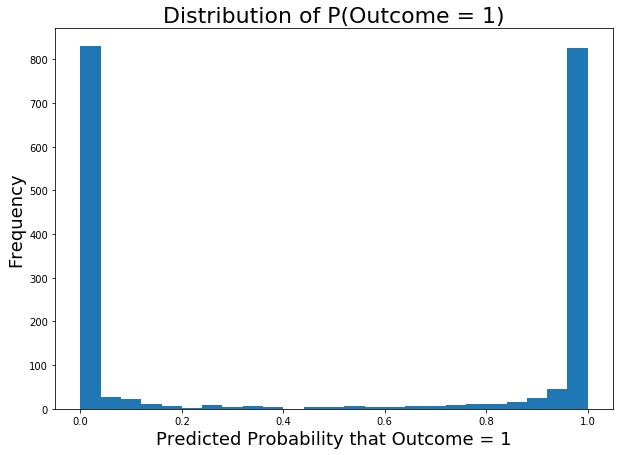

In [39]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

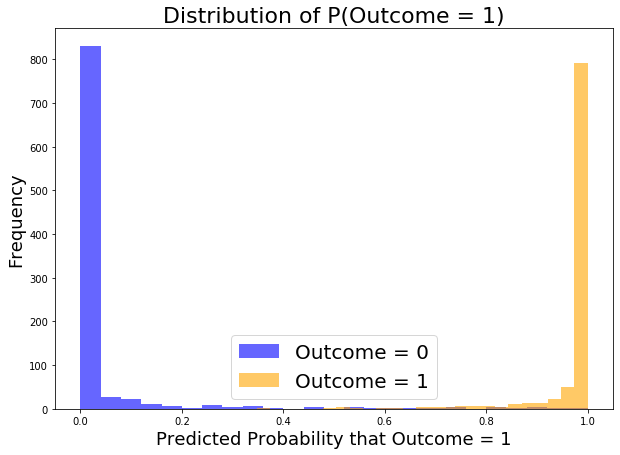

In [40]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

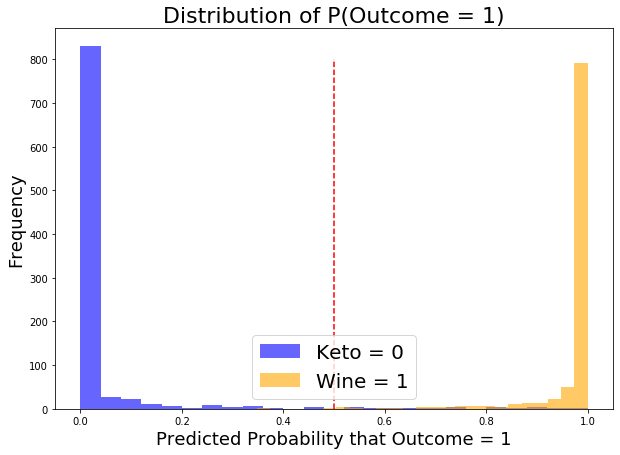

In [41]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Keto = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Wine = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 800,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

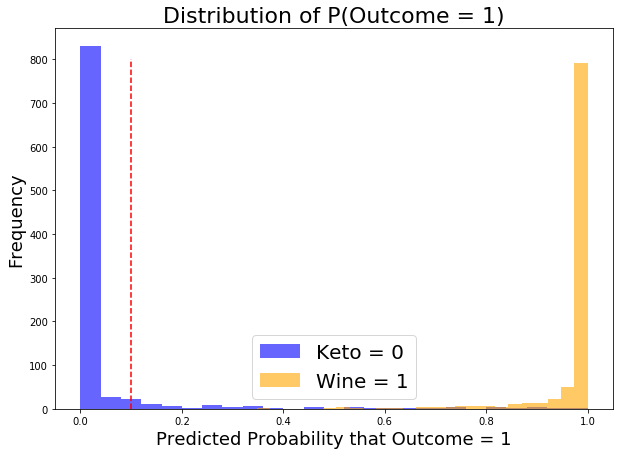

In [42]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Keto = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Wine = 1')

# Add vertical line at P(Outcome = 1) = 0.1.
plt.vlines(x=0.1,
           ymin = 0,
           ymax = 800,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

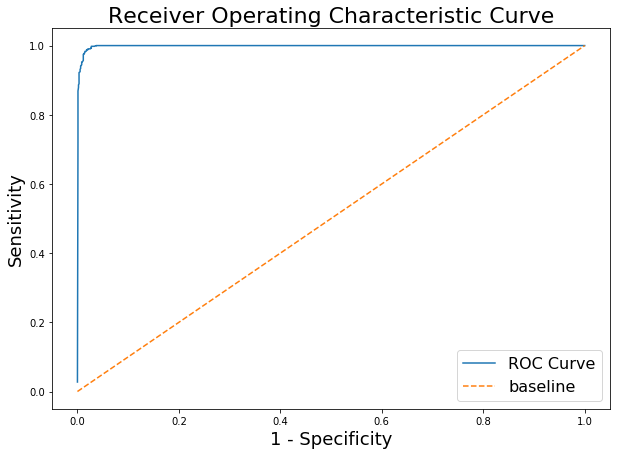

In [43]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9984900900423261

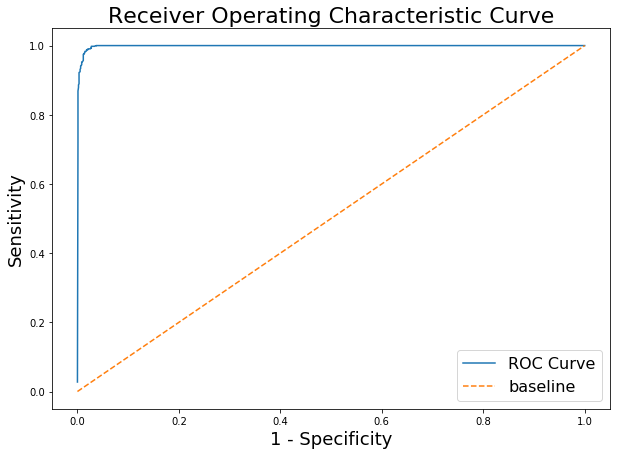

In [46]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**INSTANTIATE MULTINOMIAL NAIVE BAYES MODEL AND CONTINUE EDA**

In [47]:
model= MultinomialNB()

In [48]:
model.fit(X_train_cvec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [49]:
pred_b=model.predict(X_test_cvec)

In [50]:
pred_b

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [51]:
model.score(X_test_cvec,y_test)

0.9858118759852864

In [52]:
confusion_matrix(y_test, # True values.
                 pred_b)  

array([[932,  20],
       [  7, 944]], dtype=int64)

In [53]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, pred_b).ravel()

# Note that .ravel() will arrange items in a one-dimensional array.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html

In [54]:
# What is the specificity of our test set?

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.979


In [55]:
# What is the sensitivity of our test set?

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9926


In [56]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_test_cvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

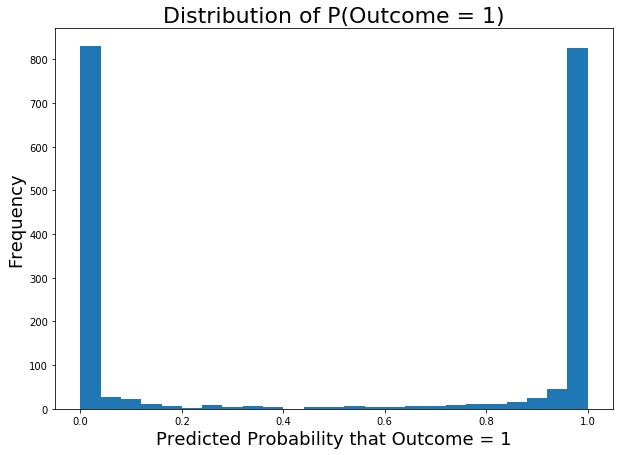

In [57]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

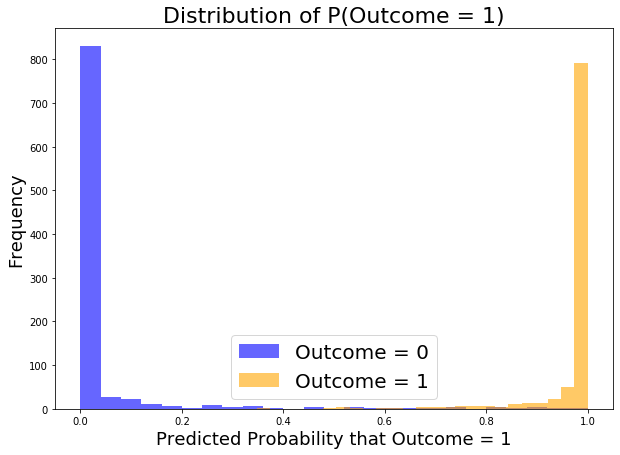

In [58]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

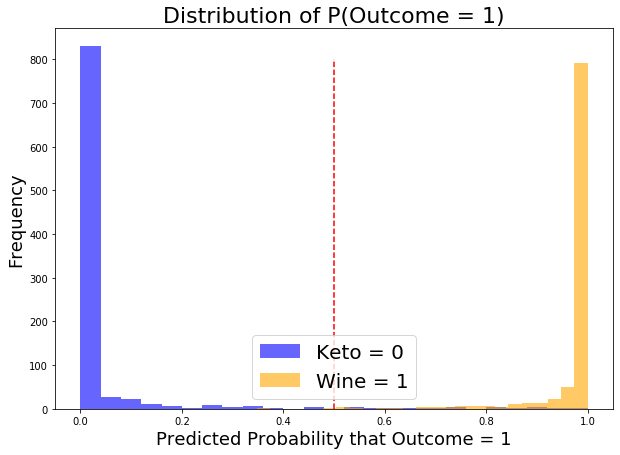

In [59]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Keto = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Wine = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 800,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

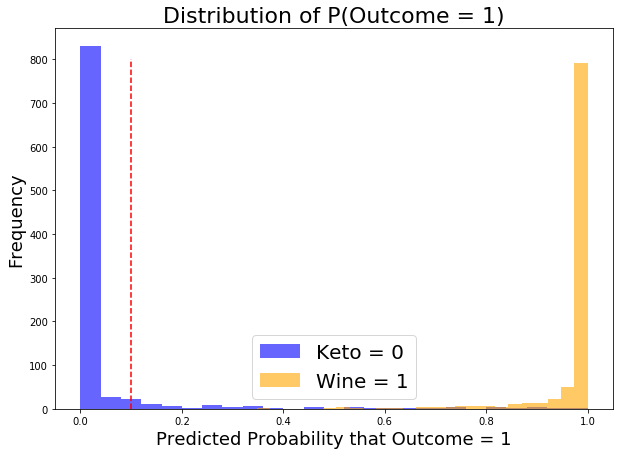

In [60]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Keto = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Wine = 1')

# Add vertical line at P(Outcome = 1) = 0.1.
plt.vlines(x=0.1,
           ymin = 0,
           ymax = 800,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

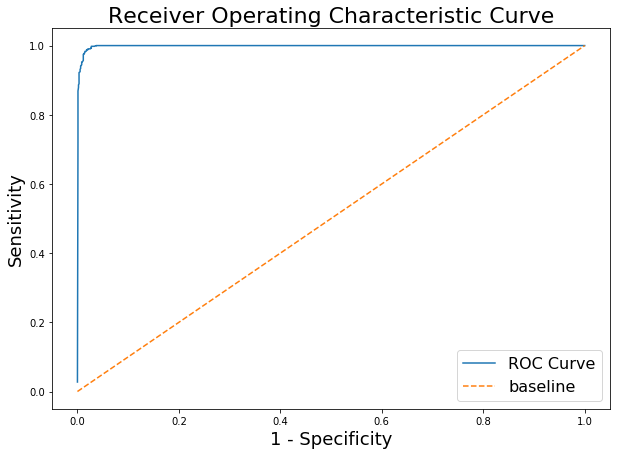

In [61]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.9984900900423261

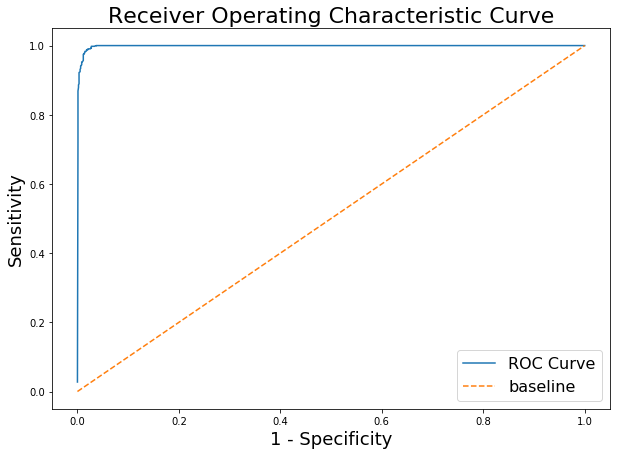

In [64]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);